<a href="https://colab.research.google.com/github/AnandShegde/pml_baselines/blob/main/pystan/8_schools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import pystan
except:
  %pip install -qq pystan
  import pystan
import tensorflow as tf
import numpy as np
import seaborn as sns
import numpy as np
import jax
import jax.numpy as jnp
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import arviz as az

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': FAILED_PRECONDITION: No visible GPU devices.
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


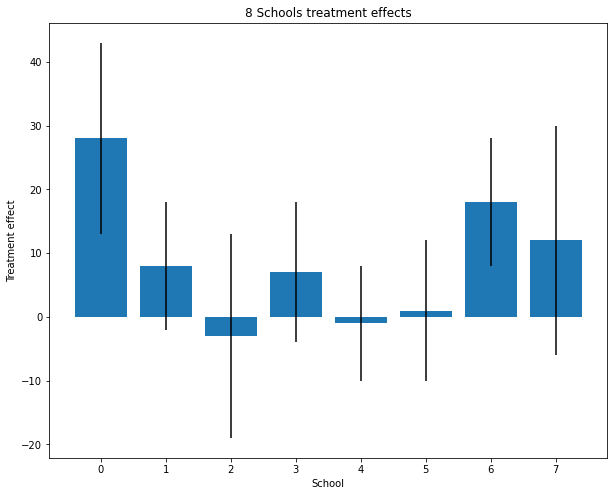

In [2]:
num_schools = 8  # number of schools
treatment_effects = jnp.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=jnp.float32)  # treatment effects
treatment_stddevs = jnp.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=jnp.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

In [7]:
schools_code = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real logtau;
  real theta[J];
}

model {
  mu ~ normal(0, 10);
  logtau ~ normal(5, 1);
  for (j in 1:J) {
      theta[j]~normal(mu,exp(logtau));
      y[j] ~ normal(theta[j], sigma[j]);
  }
}
"""

In [8]:
model_EightSchools = pystan.StanModel(model_code=schools_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9f8c47461c235b8733038c4331b2f1f7 NOW.


In [9]:
data = {
    'J':num_schools,
    'y':treatment_effects,
    'sigma':treatment_stddevs,
}

In [10]:
model_EightSchools_hmc = model_EightSchools.sampling(data=data, chains=8, warmup=500, iter=1500)

In [11]:
model_EightSchools_hmc

Inference for Stan model: anon_model_9f8c47461c235b8733038c4331b2f1f7.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         5.76    0.08   5.47   -5.4    2.3   5.86   9.42  16.25   4206    1.0
logtau     2.44    0.02   0.53   1.28   2.13   2.47   2.81   3.38    728   1.01
theta[1]  14.69    0.16  10.83  -4.54   7.26  13.74  21.41  38.72   4824    1.0
theta[2]   7.19     0.1   7.87  -8.28   2.07   7.15  12.25  23.15   6864    1.0
theta[3]   2.78    0.16   10.5  -19.2  -3.55   3.07   9.73  22.43   4468    1.0
theta[4]   6.68     0.1   8.42  -9.86   1.21   6.65  12.11  23.48   7132    1.0
theta[5]   1.75     0.1   7.43 -13.74  -3.09   1.91    6.8  15.64   5117    1.0
theta[6]   3.39    0.13   8.42 -13.81  -2.05   3.49   9.08  19.33   4147    1.0
theta[7]  12.79    0.11    8.2  -2.76   7.21  12.49  18.15   29.8   5545    1.0
theta[8]   7

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8cbc6db790>,
      dtype=object)

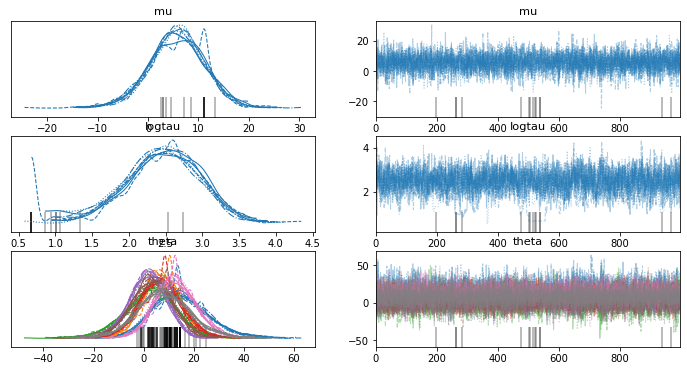

In [12]:
az.plot_trace(model_EightSchools_hmc)

In [13]:
model_EightSchools_df = model_EightSchools_hmc.to_dataframe()
model_EightSchools_df

,chain,draw,warmup,mu,logtau,theta[1],theta[2],theta[3],theta[4],theta[5],theta[6],theta[7],theta[8],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,9.303768,1.887648,0.474327,9.500575,1.756566,10.996817,-1.741649,10.931566,9.777487,10.667840,-25.967501,0.909157,0.329723,3,7,0,30.728268
1,0,1,0,11.939871,2.354407,22.597237,5.487054,7.400522,-3.712884,13.297955,6.044204,16.321484,2.646847,-27.883574,0.938472,0.329723,3,15,0,31.086356
2,0,2,0,5.108921,2.216692,16.219395,4.139799,12.784001,7.897687,6.704153,-3.493487,17.157675,13.242681,-25.909564,0.983132,0.329723,3,15,0,29.592463
3,0,3,0,5.445103,3.178906,17.886648,-13.407380,-10.686297,4.947333,-1.095419,2.759029,18.540670,18.944945,-30.995608,0.930830,0.329723,3,7,0,34.621088
4,0,4,0,5.863887,2.895903,15.609734,15.900560,15.418375,21.331778,-5.994004,20.487858,11.825104,-16.152529,-32.992591,0.971126,0.329723,4,15,0,40.287148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7,995,0,2.641065,3.748595,31.934509,4.972564,1.909573,2.157654,-13.088245,0.697679,-0.064591,-15.537013,-35.138096,1.000000,0.376789,3,15,0,39.286372
7996,7,996,0,1.622749,2.856107,39.274002,-4.646043,4.244425,4.181981,-6.308150,-4.735923,18.617448,4.127082,-29.873435,0.977573,0.376789,3,15,0,37.669171
7997,7,997,0,0.706599,3.359756,31.269404,3.344465,2.990081,17.194122,-6.943311,-3.236598,19.535764,9.172307,-30.210859,0.928880,0.376789,3,15,0,34.235472
7998,7,998,0,11.263281,2.641587,22.676666,18.324325,-15.350020,2.874412,6.394777,-9.310825,22.047629,1.485936,-30.647445,0.972386,0.376789,3,7,0,34.830441


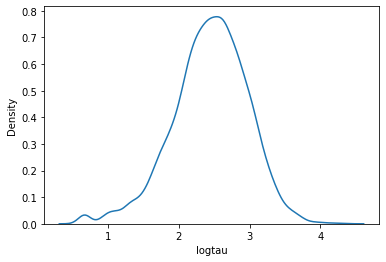

In [15]:
logtau_hmc = model_EightSchools_df['logtau']
sns.kdeplot(logtau_hmc,label="logtau")

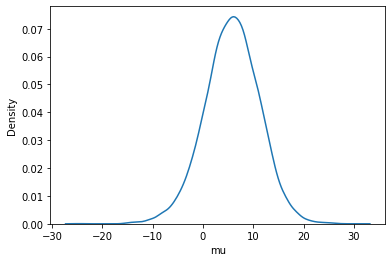

In [16]:
mu_hmc = model_EightSchools_df['mu']
sns.kdeplot(mu_hmc,label="mu")

In [23]:
(np.array(model_EightSchools_df['theta[1]']))

array([ 0.47432664, 22.59723675, 16.21939477, ..., 31.26940421,
       22.67666648,  6.66904636])

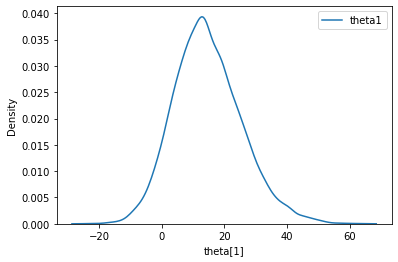

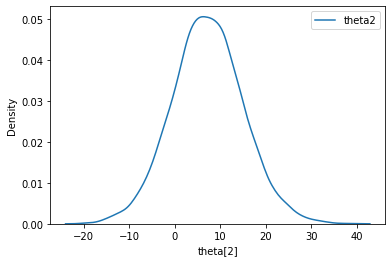

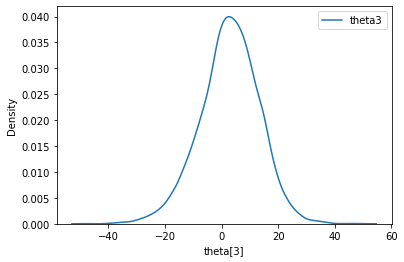

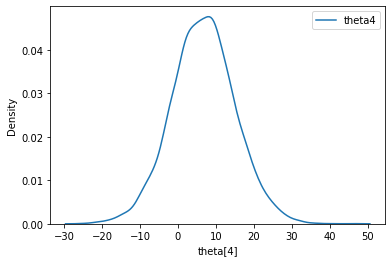

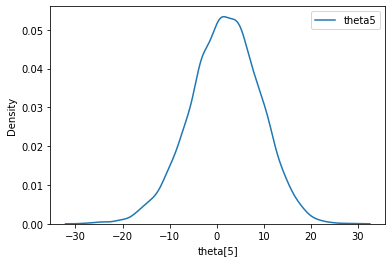

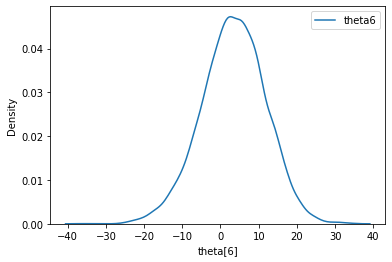

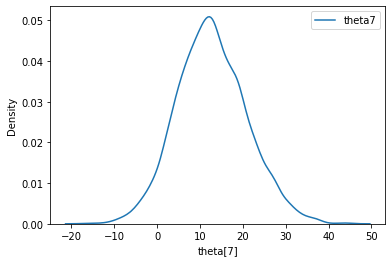

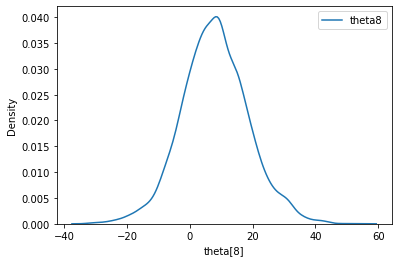

In [25]:
for i in range(1,9):
  sns.kdeplot(model_EightSchools_df['theta['+str(i)+']'],label=f"theta{str(i)}")
  # az.plot_trace(np.array(model_EightSchools_df['theta['+str(i)+']']))
  plt.legend()
  plt.show()